In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

os.chdir('/content/drive/My Drive/GitHub Repositories/Research Paper Contribution/Cascaded Model/Synthetic Data')
base_path = './dataset'
imsize = 128

**Genearte DataSet**

In [0]:
import numpy as np
from skimage import filters
import h5py
import os
from skimage.draw import circle

def map_image_to_intensity_range(image, min_o, max_o, percentiles=0):

    # If percentile = 0 uses min and max. Percentile >0 makes normalisation more robust to outliers.

    if image.dtype in [np.uint8, np.uint16, np.uint32]:
        assert min_o >= 0, 'Input image type is uintXX but you selected a negative min_o: %f' % min_o

    if image.dtype == np.uint8:
        assert max_o <= 255, 'Input image type is uint8 but you selected a max_o > 255: %f' % max_o

    min_i = np.percentile(image, 0 + percentiles)
    max_i = np.percentile(image, 100 - percentiles)

    image = (np.divide((image - min_i), max_i - min_i) * (max_o - min_o) + min_o).copy()

    image[image > max_o] = max_o
    image[image < min_o] = min_o

    return image

def prepare_data(out_path,
                 effect_size=50.,
                 num_samples=100,
                 image_size=100,
                 moving_effect=True,
                 scale_intensities_to_one=True,
                 save_type='hdf5'):

    # Constants
    stdbckg = 50.  #std deviation of the background
    stdkernel = 2.5  #std deviation of the Gaussian smoothing kernel
    block1size = 10  #size of the first block
    block2size = 10  #size of the 2nd block

    offset = int((image_size / 3.5) + 0.5)
    block2offset_ = np.asarray([offset, offset])
    block3size = 10  #size of the 3rd block
    block3offset_ = np.asarray([-offset, -offset])
    norm_percentile = 0

    numNsamples = num_samples // 2
    numP1samples = np.int(num_samples // 4)
    numP2samples = np.int(num_samples // 4)

    Features = np.zeros([image_size ** 2, numNsamples + numP1samples + numP2samples])
    GT = np.zeros([image_size ** 2, numNsamples + numP1samples + numP2samples])
    Labels = np.zeros(numNsamples+numP1samples+numP2samples)
    half_imsize = np.int(image_size / 2)

    # Generate images of class 1 with subtype A (box in the centre and upper left)
    for n in range(numP1samples):

        I = np.zeros([image_size, image_size])

        if moving_effect:
            block2offset = block2offset_ + np.random.randint(-5, 5, size=2)
        else:
            block2offset = block2offset_

        rr, cc = circle(half_imsize+40, half_imsize+40, 8, [image_size, image_size])
        I[rr,cc] = effect_size

        GT[:,n] = I.reshape(image_size ** 2) > 0
        noise = np.random.normal(scale=stdbckg, size=np.asarray([image_size, image_size]))
        smnoise = filters.gaussian(noise, stdkernel)
        smnoise = smnoise / np.std(smnoise) * stdbckg
        J = I + smnoise

        if scale_intensities_to_one:
            J = map_image_to_intensity_range(J, -1, 1, percentiles=norm_percentile)

        Features[:,n] = J.reshape(image_size ** 2)
        Labels[n] = 1

    # Generate images of class 1 with subtype B (box in the centre and lower right)
    for n in range(numP2samples):

        I = np.zeros([image_size, image_size])

        if moving_effect:
            block3offset = block3offset_ + np.random.randint(-5, 5, size=2)
        else:
            block3offset = block3offset_

        rr, cc = circle(half_imsize-40, half_imsize-40, 8, [image_size, image_size])
        I[rr,cc] = effect_size

        GT[:,n+numP1samples] = I.reshape(image_size ** 2) > 0
        noise = np.random.normal(scale=stdbckg, size=np.asarray([image_size, image_size]))
        smnoise = filters.gaussian(noise, stdkernel)
        smnoise = smnoise / np.std(smnoise) * stdbckg
        J = I + smnoise

        if scale_intensities_to_one:
            J = map_image_to_intensity_range(J, -1, 1, percentiles=norm_percentile)

        Features[:,n+numP1samples] = J.reshape(image_size ** 2)
        Labels[n+numP1samples] = 1

    # Generate image of class 0 (only noise)
    for n in range(numNsamples):

        I = np.zeros([image_size, image_size])
        noise = np.random.normal(scale=stdbckg, size=np.asarray([image_size, image_size]))
        smnoise = filters.gaussian(noise, stdkernel)
        smnoise = smnoise / np.std(smnoise) * stdbckg
        J = I + smnoise

        if scale_intensities_to_one:
            J = map_image_to_intensity_range(J, -1, 1, percentiles=norm_percentile)

        Features[:,n+numP1samples+numP2samples] = J.reshape(image_size ** 2)
        Labels[n+numP1samples+numP2samples] = 0

    if save_type == 'text':
        txt_folder = os.path.dirname(out_path)
        np.savetxt(os.path.join(txt_folder, 'features_moving.txt'), Features, fmt='%1.4f')
        np.savetxt(os.path.join(txt_folder, 'labels_moving.txt'), Labels, fmt='%d')
        np.savetxt(os.path.join(txt_folder, 'gt_features_moving.txt'), GT, fmt='%d')

    elif save_type == 'pickle':
        np.savez_compressed(out_path, features=Features, labels=Labels, gt=GT)

    elif save_type == 'hdf5':
        with h5py.File(out_path, 'w') as hdf5_file:
            #Features = (Features - np.min(Features))/(np.max(Features) - np.min(Features))
            hdf5_file.create_dataset('features', data=Features, dtype=np.float32)
            hdf5_file.create_dataset('labels', data=Labels, dtype=np.uint8)
            hdf5_file.create_dataset('gt', data=GT, dtype=np.uint8)

    else:
        raise ValueError('Unknown save_type: %s' % save_type)

**Generate And Load DataSet**

In [0]:
prepare_data(os.path.join(base_path, 'syntheticDataset.hdf5'), scale_intensities_to_one=True, num_samples=1000, effect_size=500, image_size=imsize)#10000

In [5]:
with h5py.File(os.path.join(base_path, 'syntheticDataset.hdf5'), 'r') as f:
  features = f['features'].value
  labels = f['labels'].value
  gts = f['gt'].value
print('DataSet Loaded Successfully')

gts = np.reshape(gts, [imsize, imsize, -1])
gts = np.transpose(gts, [2, 0, 1])

features = np.reshape(features, [imsize, imsize, -1])
features = np.transpose(features, [2, 0, 1])

DataSet Loaded Successfully


In [6]:
features.min()

-1.0

In [7]:
print(features.shape)
print(labels.shape)
print(gts.shape)

(1000, 128, 128)
(1000,)
(1000, 128, 128)


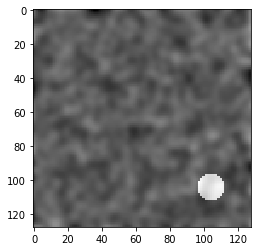

1


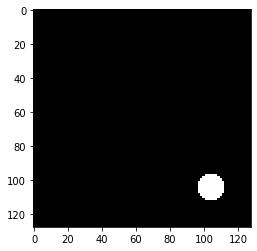

In [8]:
import matplotlib.pyplot as plt
index = 100
plt.imshow(features[index], cmap='gray')
plt.show()
print(labels[index])
plt.imshow(gts[index], cmap='gray')
plt.show()



1


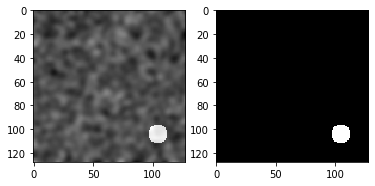

0


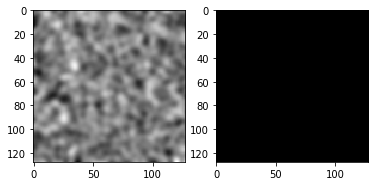

In [9]:
import matplotlib.pyplot as plt
index = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(features[index], cmap='gray')
plt.subplot(1,2,2)
print(labels[index])
plt.imshow(gts[index], cmap='gray')
plt.show()

index = 700
plt.figure()
plt.subplot(1,2,1)
plt.imshow(features[index], cmap='gray')
plt.subplot(1,2,2)
print(labels[index])
plt.imshow(gts[index], cmap='gray')
plt.show()

In [10]:
class_0 = os.path.join(base_path, '0')
class_1 = os.path.join(base_path, '1')

if not os.path.exists(class_0):
  os.makedirs(class_0)
  
if not os.path.exists(class_1):
  os.makedirs(class_1)

class_0_indexes = np.where(labels==0)

normal = []
infected = []
normal_groundtruth = []
infected_groundtruth = []
for index in class_0_indexes:
  normal.append(features[index])
  normal_groundtruth.append(gts[index])
normal = np.array(normal).reshape(-1, imsize, imsize, 1)
normal_groundtruth = np.array(normal_groundtruth).reshape(-1, imsize, imsize, 1)
print(normal.shape)
print(normal_groundtruth.shape)

class_1_indexes = np.where(labels==1)
for index in class_1_indexes:
  infected.append(features[index])
  infected_groundtruth.append(gts[index])

infected = np.array(infected).reshape(-1, imsize, imsize, 1)
infected_groundtruth = np.array(infected_groundtruth).reshape(-1, imsize, imsize, 1)
print(infected.shape)
print(infected_groundtruth.shape)

(500, 128, 128, 1)
(500, 128, 128, 1)
(500, 128, 128, 1)
(500, 128, 128, 1)


In [11]:
normal_norm = []
for i, content in enumerate(normal):
  img = content.copy()
  img = ((img - np.min(img))/(np.max(img) - np.min(img)))*1.3
  img = (img - np.mean(img))/np.std(img)
  normal_norm.append(img)
  print('\rProcessing Non-Healthy Files:', str(i+1) + '/' + str(len(normal)), end='')
normal = np.asarray(normal_norm)
print('')

infected_norm = []
for i, content in enumerate(infected):
  img = content.copy()
  img = (img - np.min(img))/(np.max(img) - np.min(img))
  img = (img - np.mean(img))/np.std(img)
  infected_norm.append(img)
  print('\rProcessing Healthy Files:', str(i+1) + '/' + str(len(infected_norm)), end='')
infected = np.asarray(infected_norm)

Processing Non-Healthy Files: 500/500
Processing Healthy Files: 500/500

In [0]:
np.save(os.path.join(class_0, 'images'), normal)
np.save(os.path.join(class_0, 'masks'), normal_groundtruth)

np.save(os.path.join(class_1, 'images'), infected)
np.save(os.path.join(class_1, 'masks'), infected_groundtruth)

In [0]:
print(infected.max(), normal.max())

9.192526 12.477212


In [13]:
print(np.load(os.path.join(class_1, 'images.npy')).max())
print(np.load(os.path.join(class_0, 'images.npy')).max())

9.134058
12.160168


In [14]:
import numpy as np
class_0 = os.path.join(base_path, '0')
class_1 = os.path.join(base_path, '1')

print(np.load(os.path.join(class_0, 'images.npy')).max())
print(np.load(os.path.join(class_1, 'images.npy')).max())

1.0
1.0


In [15]:
print(infected.max(), normal.max())

9.134058 12.160168


In [16]:
infected.max()

9.134058

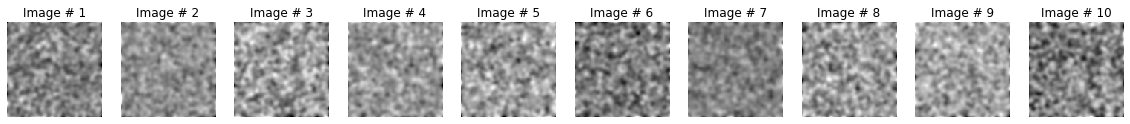

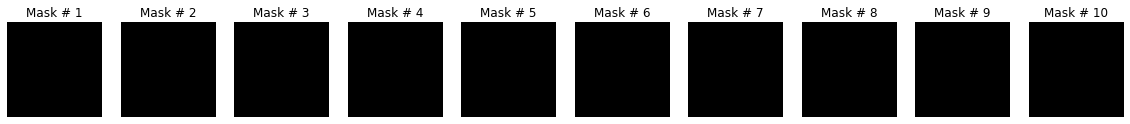

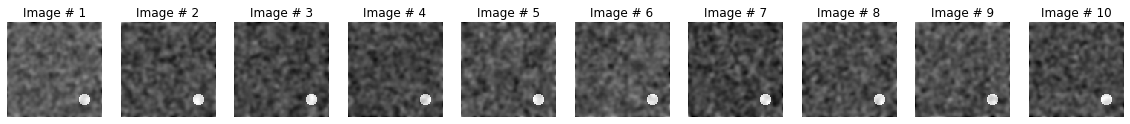

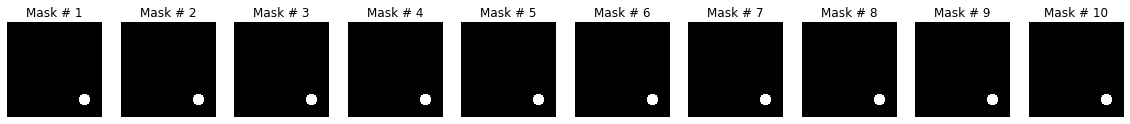

In [17]:
from_images = 100
to_images = 110

images_0 = normal[from_images:to_images]
masks_0 = normal_groundtruth[from_images:to_images]


images_1 = infected[from_images:to_images]
masks_1 = infected_groundtruth[from_images:to_images]

def plot_images(images, masks):
  plt.figure(1, figsize=(20,20))
  for i in range(images.shape[0]):
    plt.subplot(1, 10, i+1).set_title('Image # {}' .format(i+1))
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize=(20,20))
  for i in range(masks.shape[0]):
    plt.subplot(1, 10, i+1).set_title('Mask # {}' .format(i+1))
    plt.imshow(masks[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.show()
  plt.close()

plot_images(images_0, masks_0)
plot_images(images_1, masks_1)